# ASR Dataset EDA

## 0. Download Subset of Data

In [ ]:
import gdown
import zipfile
import os
from utils import get_data_dir, get_project_root, get_processed_data_dir

# 1. Download the file from Google Drive
url = "https://drive.google.com/uc?id=1rHenEIWb10HqrCp1NQ9fyRWAYlF_er2H"
output = os.path.join(get_project_root() / "zipped_data", "speech_sample.zip")
gdown.download(url, output, quiet=True)

extract_dir = get_processed_data_dir("asr")

# 3. Unzip the file into the target directory
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


## 1. Import necessary libraries

In [1]:
import json
import librosa
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
from utils import get_data_dir, get_project_root, get_processed_data_dir
from IPython.display import Audio

## 2. Basic EDA

In [2]:
# Load the audio clips path and sentences from test.json
data_path = get_processed_data_dir("asr/converted_clips")
test_json_path = data_path / "test.json"
with open(test_json_path, 'r') as f:
    data = json.load(f)

audio_files = data[0:3]
audio_files

[{'key': '/home/kayc/Code/Fuse/ASR-with-Speech-Sentiment-and-Text-Summarizer/data/processed/asr/converted_clips/clips/common_voice_en_39747708.flac',
  'text': 'The original mansion was destroyed in the French Revolution'},
 {'key': '/home/kayc/Code/Fuse/ASR-with-Speech-Sentiment-and-Text-Summarizer/data/processed/asr/converted_clips/clips/common_voice_en_39749320.flac',
  'text': 'The port has grainhandling and some warehousing facilities'},
 {'key': '/home/kayc/Code/Fuse/ASR-with-Speech-Sentiment-and-Text-Summarizer/data/processed/asr/converted_clips/clips/common_voice_en_40058417.flac',
  'text': 'After the incident she took a break from Twitter'}]

Sample Rate: 16000


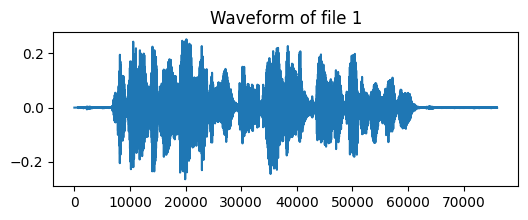

Sample Rate: 16000


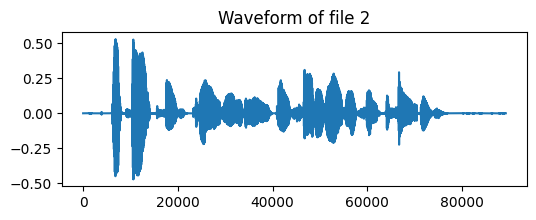

Sample Rate: 16000


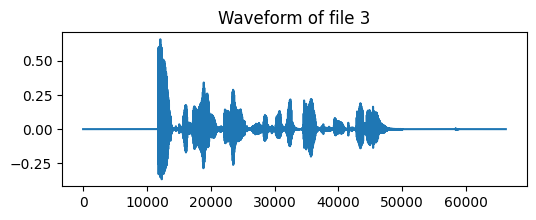

In [3]:
# Load the sample audio file
for idx, audio_info in enumerate(audio_files):
    audio_path = audio_info['key']
    
    # Load the sample audio file
    waveform, sample_rate = torchaudio.load(audio_path, backend="soundfile")

    print(f"Sample Rate: {sample_rate}")

    display(Audio(audio_path,))
    
    plt.figure(figsize=(6, 2))
    plt.plot(waveform.t().numpy())
    plt.title(f"Waveform of file {idx+1}")
    plt.show()


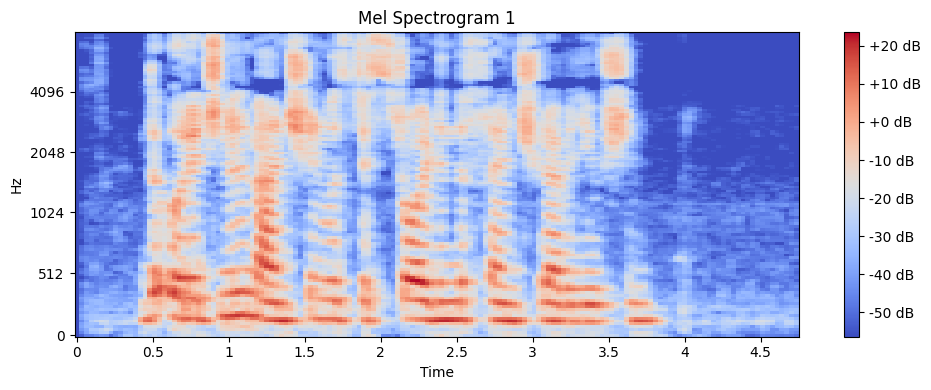

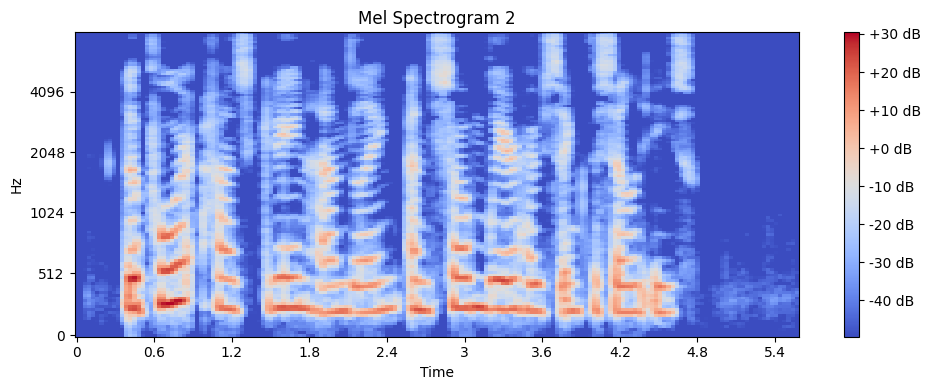

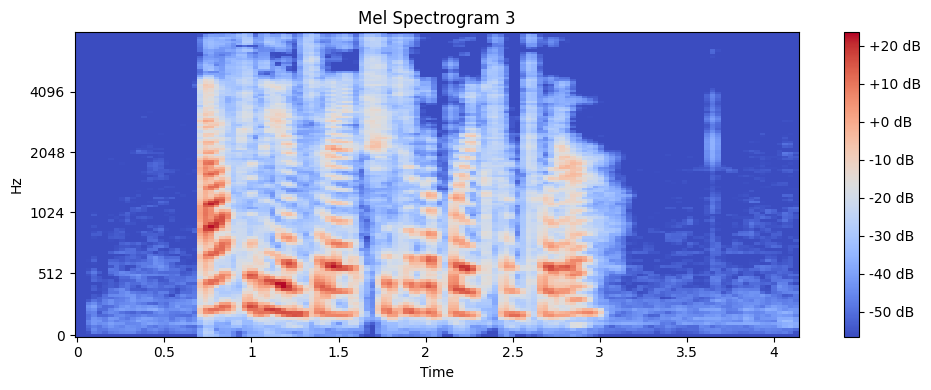

In [5]:
for idx, audio_info in enumerate(audio_files):
    audio_path = audio_info['key']
    waveform, sample_rate = torchaudio.load(audio_path, backend="soundfile")
    waveform_np = waveform.numpy().flatten()

    # Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=waveform_np, sr=sample_rate, n_mels=128, fmax=sample_rate/2)
    log_spectrogram = librosa.power_to_db(spectrogram)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title(f'Mel Spectrogram {idx+1}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

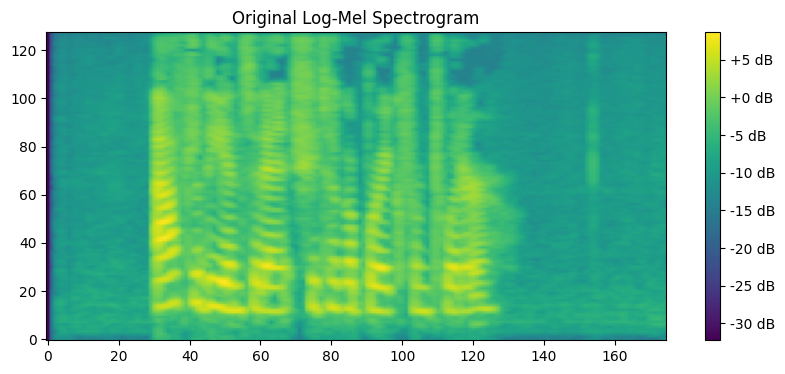

In [6]:
# Defining LogMelSpec transformation
log_mel_spec_transform = transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=128,
    hop_length=380,
    n_fft = 1024*2
)

# Compute the log-mel spectrogram
log_mel_spec = log_mel_spec_transform(waveform)
log_mel_spec = torch.log(log_mel_spec + 1e-14)  # Avoid log(0)

# Display the original spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spec.squeeze(0).numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title("Original Log-Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

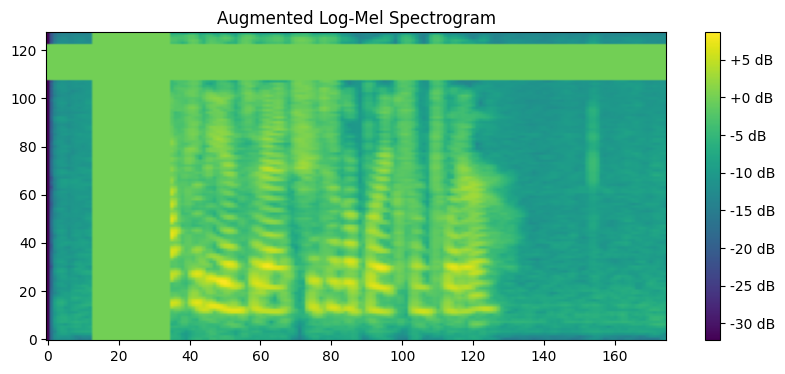

In [7]:
# SpecAugment transformations
spec_augment = nn.Sequential(
                transforms.FrequencyMasking(freq_mask_param=30),
                transforms.TimeMasking(time_mask_param=70)
)

# Applying SpecAugment
augmented_log_mel_spec = spec_augment(log_mel_spec)

# Display augmented spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(augmented_log_mel_spec.squeeze(0).numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title("Augmented Log-Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

In [8]:
log_mel_spec.squeeze(0).numpy(), log_mel_spec.squeeze(0).shape

(array([[-32.23619  , -17.356323 , -12.461226 , ..., -14.848524 ,
         -12.176379 , -10.9852705],
        [-32.23619  , -17.239346 , -11.9369135, ..., -11.445574 ,
         -12.069365 , -11.804672 ],
        [-32.23619  , -17.07124  , -12.005846 , ...,  -8.644784 ,
          -9.8229685, -12.05238  ],
        ...,
        [-32.23619  , -20.948929 , -15.770078 , ..., -11.706077 ,
         -11.869759 , -12.269981 ],
        [-32.23619  , -21.002054 , -16.400608 , ..., -12.916229 ,
         -12.769413 , -12.691245 ],
        [-32.23619  , -21.38118  , -16.843132 , ..., -13.537793 ,
         -13.879403 , -14.141356 ]], dtype=float32),
 torch.Size([128, 175]))

In [9]:
augmented_log_mel_spec.squeeze(0).numpy(), augmented_log_mel_spec.squeeze(0).numpy().shape

(array([[-32.23619  , -17.356323 , -12.461226 , ..., -14.848524 ,
         -12.176379 , -10.9852705],
        [-32.23619  , -17.239346 , -11.9369135, ..., -11.445574 ,
         -12.069365 , -11.804672 ],
        [-32.23619  , -17.07124  , -12.005846 , ...,  -8.644784 ,
          -9.8229685, -12.05238  ],
        ...,
        [-32.23619  , -20.948929 , -15.770078 , ..., -11.706077 ,
         -11.869759 , -12.269981 ],
        [-32.23619  , -21.002054 , -16.400608 , ..., -12.916229 ,
         -12.769413 , -12.691245 ],
        [-32.23619  , -21.38118  , -16.843132 , ..., -13.537793 ,
         -13.879403 , -14.141356 ]], dtype=float32),
 (128, 175))